This exercise is adapted from [Institute for Disease Modeling](https://www.idmod.org/docs/hiv/model-seir.html) and [Christian Hubbs' article](https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296) in [Towards Data Science](https://towardsdatascience.com/).

# SEIR and SEIRS models
This notebook aims to describe the differential equations that govern the classic deterministic SEIR and SEIRS compartmental models and aims to set up the modelling in a Python environment. 

In this category of models, individuals experience a long incubation duration (the “exposed” category), such that the individual is infected but not yet infectious. For example chicken pox, and even vector-borne diseases such as dengue hemorrhagic fever have a long incubation duration where the individual cannot yet transmit the pathogen to others.

SEIR stands for Susceptible - Exposed - Infectious - Recovered, which describes the flow of individuals through each compartment in the model. An extension would be the SEIRS model, where recovered people may become susceptible again, i.e. recovery does not confer lifelong immunity. Essentially: 

$$ \text{Susceptible} \to \beta \to \text{Exposed} \to \sigma \to \text{Infectious} \to \gamma \to \text{Recovered} \to \xi \to \text{Susceptible}$$

The infectious rate, $\beta$, controls the rate of spread which represents the probability of transmitting disease between a susceptible and an infectious individual. The incubation rate, $\sigma$, is the rate of latent individuals becoming infectious (average duration of incubation is $1/\sigma$). Recovery rate, $\gamma = 1/D$, is determined by the average duration, $D$, of infection. For the SEIRS model, $\xi$ is the rate which recovered individuals return to the susceptible statue due to loss of immunity.

# SEIR model
Many diseases have a latent phase during which the individual is infected but not yet infectious. This delay between the acquisition of infection and the infectious state can be incorporated within the SIR model by adding a latent/exposed population, E, and letting infected (but not yet infectious) individuals move from S to E and from E to I.

## SEIR without vital dynamics
In a closed population with no births or deaths, the SEIR model is given as such: 

$$ \frac{dS}{dt} = -\frac{\beta SI}{N} \Rightarrow (1)$$  
$$ \frac{dE}{dt} = \frac{\beta SI}{N} - \sigma E \Rightarrow (2)$$  
$$ \frac{dI}{dt} = \sigma E - \gamma I \Rightarrow (3)$$  
$$ \frac{dS}{dt} = \gamma I \Rightarrow (4)$$  

where $N = S + E + I + R$ is the total population.

Here, we have four ordinary differential equations (ODEs) with parameters $\sigma, \beta, \text{and } \gamma$:
- $\sigma$ is the incubation rate, i.e. inverse of incubation period
- $\beta$ is the average contact rate in the population i.e. transmission rate, and 
- $\gamma$ is the infectious rate, i.e. inverse of the mean infectious period

Equation (1) is the change in people susceptible to the disease, and is moderated by the number of infected people and their contact with the infected. Equation (2) gives the people who have been exposed to the disease; it grows based on the contact rate and decreases based on the incubation period whereby people then become infected.

Equation (3) gives us the change in infected people based on the exposed population and the incubation period. It decreases based on the infectious period, so the higher $\gamma$ is, the more quickly people die/recover and move on to the final stage in Equation (4).

Additionally, we have the $R_0$ value:

$$ R_0 = \frac{\beta}{\gamma} \implies (5) $$


### Modelling SEIR 
[An article by the CDC](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) provides us with the following parametric estimates:
- Mean infectious period: 7 days $\to \gamma = \frac{1}{7}$. 
- Median incubation period = 4 days $\to \sigma = 0.25$
- Median $R_0$ = 5.8

Plugging the $R_0$ and $\gamma$ values into equation (5), we get an estimate of $\beta = \frac{5.8}{7}$

### Base SEIR model in Python

In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

In [2]:
def base_seir_model(init_vals, params, t, int_only=False):
    '''
    Runs a base SEIR deterministic model
    Returns dataframe with the levels and key statistics indexed by timestep
    '''
    # SEIR initialisation
    S_0, E_0, I_0, R_0 = init_vals 
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    sigma, beta, gamma, n = params 
    
    # initialise additional statistics
    infections_daily_0 = 0
    I_daily = [infections_daily_0]
    
    dt = t[1] - t[0]
    for _ in t[1:]:
        #base SEIR model
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - sigma*E[-1])*dt
        next_I = I[-1] + (sigma*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        
        #additional stats
        next_I_d = sigma*E[-1]*dt
        I_daily.append(next_I_d)

    # convert to pandas Series with indexing, 
    S_series = pd.Series(S, index=t)
    E_series = pd.Series(E, index=t)
    I_series = pd.Series(I, index=t)
    R_series = pd.Series(R, index=t)
    
    # calculate additional metrics
    I_daily_series = pd.Series(I_daily, index=t)
    I_cum = I_daily_series.cumsum()
    log_cum = np.log10(I_cum*n)
    r_growth = I_cum.iloc[1:]/I_cum.iloc[:-1].values - 1
    r_growth = r_growth.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_decay = I_daily_series.iloc[1:]/I_daily_series.iloc[:-1].values - 1
    r_decay = r_decay.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_growth.replace(np.inf, np.nan, inplace=True)
    r_decay.replace(np.inf, np.nan, inplace=True)

    df = pd.DataFrame({
        'Susceptible population': S,
        'Exposed population': E,
        'Infected population': I,
        'Recovered population': R,
        'Daily infections': I_daily_series,
        'Cumulative infections': I_cum,
        'Log10 cumulative infections': log_cum,
        'Rate of growth': r_growth,
        'Rate of decay': r_decay,
    })
    
    unit_people = ['Susceptible population', 'Exposed population', 'Infected population', 'Recovered population', 'Daily infections', 'Cumulative infections']
    
    for e in unit_people: # convert percentages back to no. of people
        df[e] = df[e] * n
        if int_only: # condition to return only integers
            df[e] = df[e].apply(np.ceil)
    
    return df

In [3]:
# initial values as a tuple (S, E, I, R)
n = 10000 # this is our population size
init_vals = 1-1/n, 1/n, 0, 0

# configure our parameters as a tuple (sigma, beta, gamma, n)
sigma = 0.25
beta = 5.8/7
gamma = 1/7
params = sigma, beta, gamma, n

# setup the environment
t_max = 100 # days in our simulation
dt = .1 # timestep
t = np.linspace(0, t_max, int(t_max/dt) + 1) 

/Users/JiangXu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


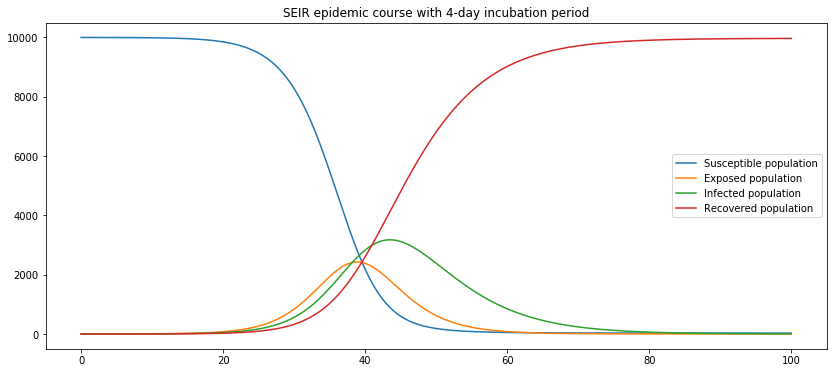

In [4]:
# run the simulation and plot results
results = base_seir_model(init_vals, params, t, int_only=False)
SEIR_col = ['Susceptible population', 'Exposed population', 'Infected population', 'Recovered population']
results.loc[:, SEIR_col].plot(figsize=(14,6), legend=True, title='SEIR epidemic course with 4-day incubation period')

__Discussion:__  
Since the latency delays the start of the individual’s infectious period, the secondary spread from an infected individual will occur at a later time compared with an SIR model, which has no latency. Therefore, including a longer latency period will result in slower initial growth of the outbreak. However, since the model does not include mortality, the basic reproductive number, $R_0 = \frac{\beta}{\gamma}$, does not change.

The complete course of outbreak is observed. After the initial fast growth, the epidemic depletes the susceptible population. Eventually the virus cannot find enough new susceptible people and dies out. Introducing the incubation period does not change the cumulative number of infected individuals.

In [5]:
def plot_summary(metric, ax, dateindex=False):
    '''
    Make plots and define formatting for each metric in summary dataframe 
    '''
    ax.set_title(metric.columns[0])
    index = metric.index
    values = metric.values
    
    # Plot line
    ax.plot(index, values, c='b')
    
    # Formatting
    if dateindex: # capability for dateindex not ready yet
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    
    if metric.columns[0] in ['Susceptible population', 'Exposed population', 'Infected population', 'Recovered population']:
        ax.set_ylim(0, n)
    
    ax.yaxis.tick_left()
    ax.margins(0.05)
    ax.grid(which='major', axis='y', c='k')
    fig.set_facecolor('w')

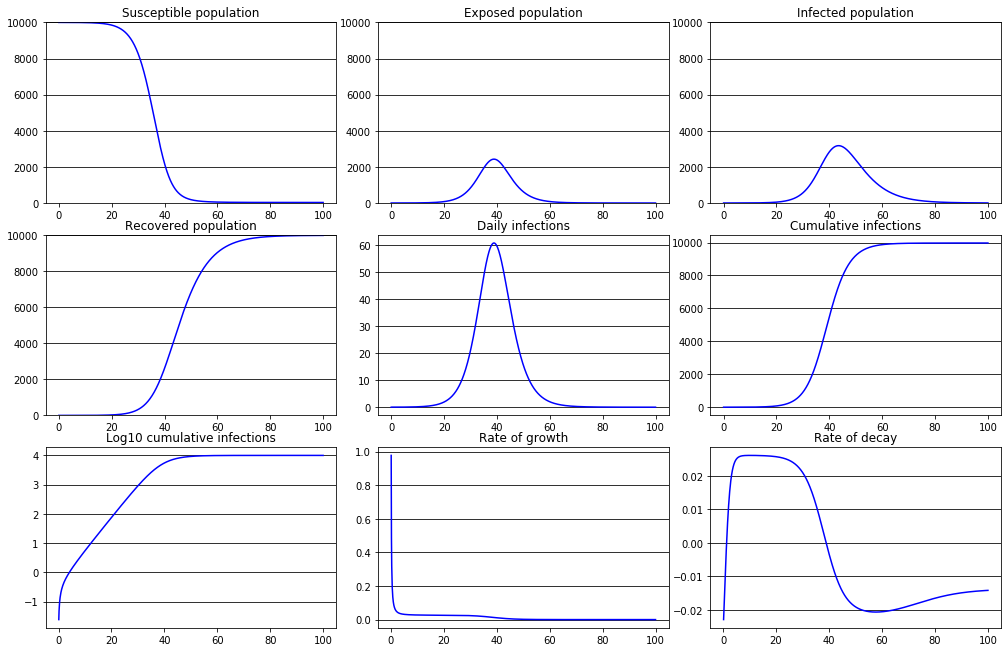

In [6]:
ncols = 3
nrows = int(np.ceil(len(results.columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows*3))
plt.tight_layout()

for i, seriesname in enumerate(results.columns):
    plot_summary(results.loc[:, [seriesname]], axes.flat[i])

## SEIRS model
The SEIR model assumes people carry lifelong immunity to a disease upon recovery, but for many diseases the immunity after infection wanes over time. In this case, the SEIRS model is used to allow recovered individuals to return to a susceptible state. Specifically, $\xi$ is the rate which recovered individuals return to the susceptible statue due to loss of immunity (i.e. inverse of immunity period). If there is sufficient influx to the susceptible population, at equilibrium the dynamics will be in an endemic state with damped oscillation. 

### SEIRS without vital dynamics
The ODE for SEIRS without vital dynamics is:

$$ \frac{dS}{dt} = -\frac{\beta SI}{N} + \xi R \Rightarrow (1)$$  
$$ \frac{dE}{dt} = \frac{\beta SI}{N} - \sigma E \Rightarrow (2)$$  
$$ \frac{dI}{dt} = \sigma E - \gamma I \Rightarrow (3)$$  
$$ \frac{dS}{dt} = \gamma I \Rightarrow (4)$$  
$$ R_0 = \frac{\beta}{\gamma} \implies (5) $$  

where $N = S + E + I + R$ is the total population.

In [7]:
def base_seirs_model(init_vals, params, t, int_only=False):
    '''
    Runs a base SEIRS deterministic model
    Returns dataframe with the levels and key statistics indexed by timestep
    '''
    # SEIR initialisation
    S_0, E_0, I_0, R_0 = init_vals 
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    sigma, beta, gamma, xi, n = params 
    
    # initialise additional statistics
    infections_daily_0 = 0
    reinfected_daily_0 = 0
    I_daily, R_daily = [infections_daily_0], [reinfected_daily_0]
    
    dt = t[1] - t[0]
    for _ in t[1:]:
        #base SEIR model
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt + (xi*R[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - sigma*E[-1])*dt
        next_I = I[-1] + (sigma*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt - (xi*R[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        
        #additional stats
        next_I_d = sigma*E[-1]*dt
        next_R_d = (xi*R[-1])*dt
        
        I_daily.append(next_I_d)
        R_daily.append(next_R_d)

    # convert to pandas Series with indexing, 
    S_series = pd.Series(S, index=t)
    E_series = pd.Series(E, index=t)
    I_series = pd.Series(I, index=t)
    R_series = pd.Series(R, index=t)
    
    # calculate additional metrics
    I_daily_series = pd.Series(I_daily, index=t)
    I_cum = I_daily_series.cumsum()
    R_daily_series = pd.Series(R_daily, index=t)
    log_cum = np.log10(I_cum*n)
    r_growth = I_cum.iloc[1:]/I_cum.iloc[:-1].values - 1
    r_growth = r_growth.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_decay = I_daily_series.iloc[1:]/I_daily_series.iloc[:-1].values - 1
    r_decay = r_decay.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_growth.replace(np.inf, np.nan, inplace=True)
    r_decay.replace(np.inf, np.nan, inplace=True)

    df = pd.DataFrame({
        'Susceptible population': S,
        'Exposed population': E,
        'Infected population': I,
        'Recovered population': R,
        'Daily infections': I_daily_series,
        'Daily reinfections': R_daily_series,
        'Cumulative infections': I_cum,
        'Log10 cumulative infections': log_cum,
        'Rate of growth': r_growth,
        'Rate of decay': r_decay,
    })
    
    unit_people = ['Susceptible population', 
                   'Exposed population', 
                   'Infected population', 
                   'Recovered population', 
                   'Daily infections', 
                   'Cumulative infections',
                   'Daily reinfections'
                  ]
    
    for e in unit_people: # convert percentages back to no. of people
        df[e] = df[e] * n
        if int_only: # condition to return only integers
            df[e] = df[e].apply(np.ceil)
    
    return df

In [8]:
# initial values as a tuple (S, E, I, R)
n = 10000 # this is our population size
init_vals = 1-1/n, 1/n, 0, 0

# configure our parameters as a tuple (sigma, beta, gamma, xi, n)
sigma = 0.25
beta = 5.8/7
gamma = 1/7
xi = 1/360 # totally unsubstantiated
params = sigma, beta, gamma, xi, n

# setup the environment
t_max = 730 # days in our simulation
dt = .1 # timestep
t = np.linspace(0, t_max, int(t_max/dt) + 1) 

/Users/JiangXu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


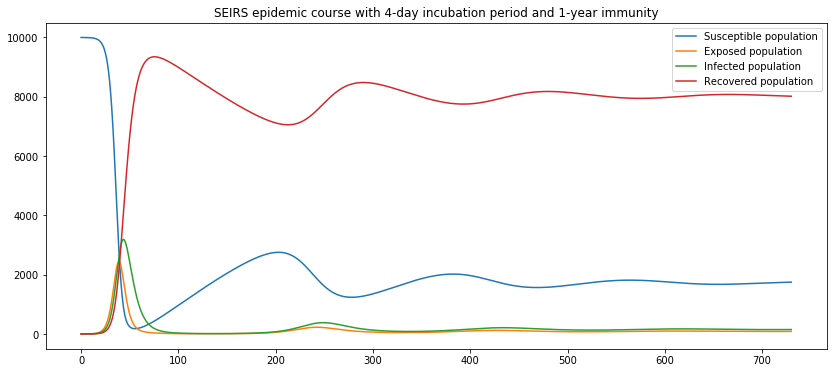

In [9]:
# run the simulation and plot results
results = base_seirs_model(init_vals, params, t, int_only=False)
SEIR_col = ['Susceptible population', 'Exposed population', 'Infected population', 'Recovered population']
results.loc[:, SEIR_col].plot(figsize=(14,6), legend=True, title='SEIRS epidemic course with 4-day incubation period and 1-year immunity')

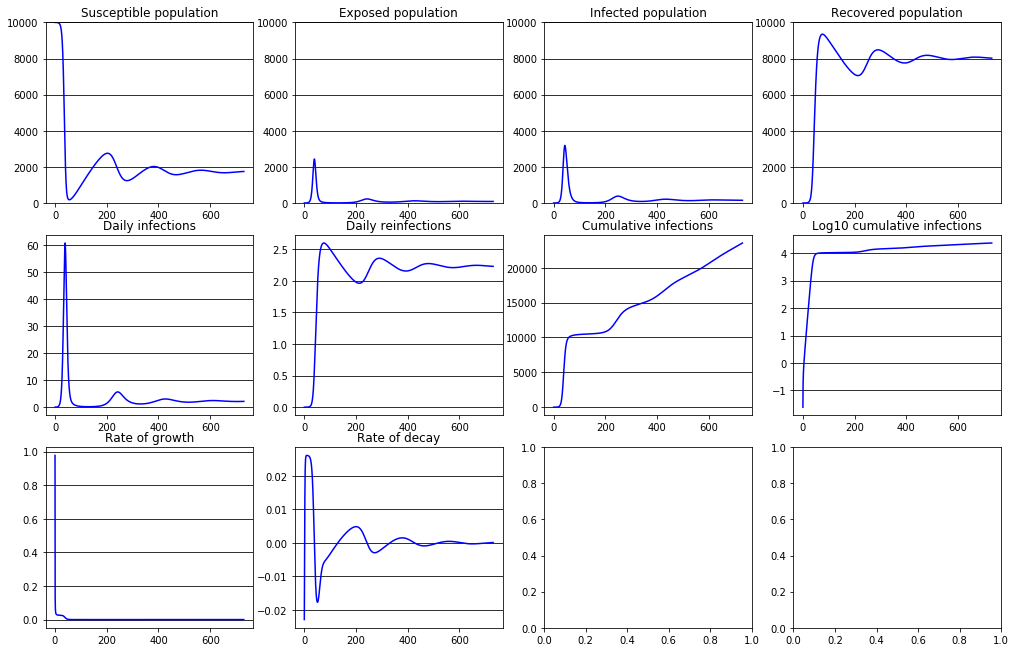

In [10]:
ncols = 4
nrows = int(np.ceil(len(results.columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows*3))
plt.tight_layout()    

for i, seriesname in enumerate(results.columns):
    plot_summary(results.loc[:, [seriesname]], axes.flat[i])

## SEIRS with social distancing parameter
For the last part of this exercise, we will capture a social distancing effect as a parameter, $\rho$.

Social distancing includes avoiding large gatherings, physical contact, and other efforts to mitigate the spread of infectious disease. According to our model, the term this is going to impact is our contact rate, $\beta$.

The social-distancing parameter $\rho$ is going to be a constant term between 0–1, where 0 indicates everyone is locked down and quarantined while 1 is equivalent to our base case above. To introduce this into our model, we’ll modify Equations (1) and (2) above by multiplying this with $\beta$ and writing Equations (1') and (2'):  

$$ \frac{dS}{dt} = -\frac{\rho\beta SI}{N} + \xi R \implies (1') $$  
$$ \frac{dE}{dt} = \frac{\rho\beta SI}{N} - \sigma E \implies (2') $$  

Herein we have our full model:

In [11]:
def full_seirs(init_vals, params, t, int_only=False):
    '''
    Runs a SEIRS deterministic model with social distancing parameter
    Returns dataframe with the levels and key statistics indexed by timestep
    '''
    # SEIR initialisation
    S_0, E_0, I_0, R_0 = init_vals 
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    sigma, beta, gamma, xi, rho, n = params 
    
    # initialise additional statistics
    infections_daily_0 = 0
    reinfected_daily_0 = 0
    I_daily, R_daily = [infections_daily_0], [reinfected_daily_0]
    
    dt = t[1] - t[0]
    for _ in t[1:]:
        #base SEIR model
        next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt + (xi*R[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - sigma*E[-1])*dt
        next_I = I[-1] + (sigma*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt - (xi*R[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        
        #additional stats
        next_I_d = sigma*E[-1]*dt
        next_R_d = (xi*R[-1])*dt
        
        I_daily.append(next_I_d)
        R_daily.append(next_R_d)

    # convert to pandas Series with indexing, 
    S_series = pd.Series(S, index=t)
    E_series = pd.Series(E, index=t)
    I_series = pd.Series(I, index=t)
    R_series = pd.Series(R, index=t)
    
    # calculate additional metrics
    I_daily_series = pd.Series(I_daily, index=t)
    I_cum = I_daily_series.cumsum()
    R_daily_series = pd.Series(R_daily, index=t)
    log_cum = np.log10(I_cum*n)
    r_growth = I_cum.iloc[1:]/I_cum.iloc[:-1].values - 1
    r_growth = r_growth.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_decay = I_daily_series.iloc[1:]/I_daily_series.iloc[:-1].values - 1
    r_decay = r_decay.append(pd.Series(np.nan, index=[t[0]])).sort_index()
    r_growth.replace(np.inf, np.nan, inplace=True)
    r_decay.replace(np.inf, np.nan, inplace=True)

    df = pd.DataFrame({
        'Susceptible population': S,
        'Exposed population': E,
        'Infected population': I,
        'Recovered population': R,
        'Daily infections': I_daily_series,
        'Daily reinfections': R_daily_series,
        'Cumulative infections': I_cum,
        'Log10 cumulative infections': log_cum,
        'Rate of growth': r_growth,
        'Rate of decay': r_decay,
    })
    
    unit_people = ['Susceptible population', 
                   'Exposed population', 
                   'Infected population', 
                   'Recovered population', 
                   'Daily infections', 
                   'Cumulative infections',
                   'Daily reinfections'
                  ]
    
    for e in unit_people: # convert percentages back to no. of people
        df[e] = df[e] * n
        if int_only: # condition to return only integers
            df[e] = df[e].apply(np.ceil)
    
    return df

In [12]:
# initial values as a tuple (S, E, I, R)
n = 10000 # this is our population size
init_vals = 1-1/n, 1/n, 0, 0

# configure our parameters as a tuple (sigma, beta, gamma, xi, n)
sigma = 0.25
beta = 5.8/7
gamma = 1/7
xi = 1/360 # totally unsubstantiated
rho = 0.8
params = sigma, beta, gamma, xi, rho, n

# setup the environment
t_max = 730 # days in our simulation
dt = .1 # timestep
t = np.linspace(0, t_max, int(t_max/dt) + 1) 

/Users/JiangXu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


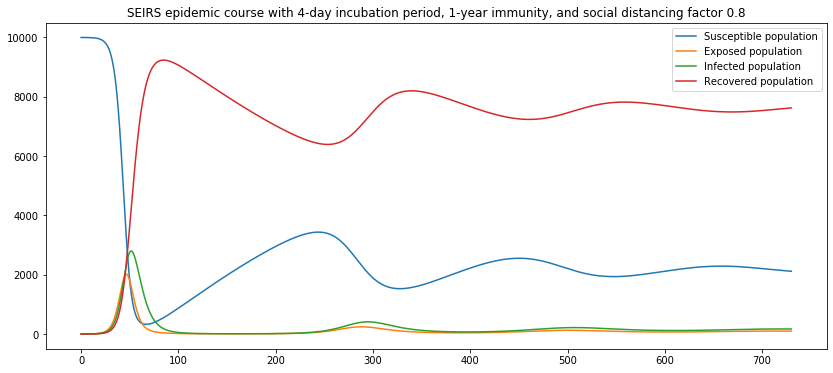

In [13]:
# run the simulation and plot results
results = full_seirs(init_vals, params, t, int_only=False)
SEIR_col = ['Susceptible population', 'Exposed population', 'Infected population', 'Recovered population']
results.loc[:, SEIR_col].plot(figsize=(14,6), legend=True, title='SEIRS epidemic course with 4-day incubation period, 1-year immunity, and social distancing factor 0.8')

### Visualising the impact of social distancing

If we set $\rho$ to a range of values, we can visualize the flattening effect as we increase our efforts to contain the disease.


/Users/JiangXu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


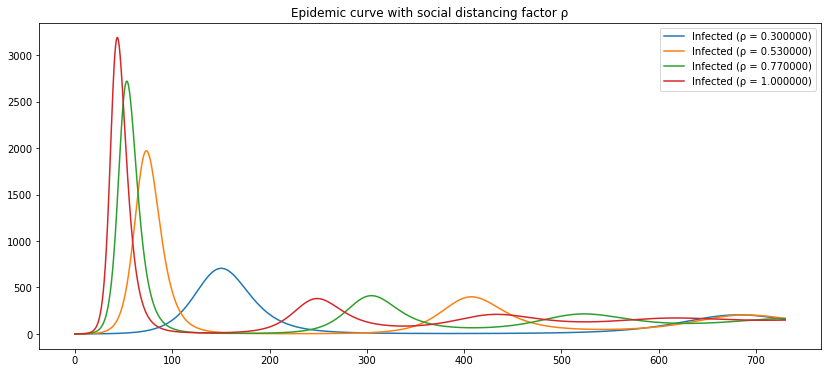

In [15]:
rho = np.linspace(0.3, 1, 4) # vary the values of rho between 0.3 to 1
param_space = list(zip((sigma,)*len(rho), 
                       (beta,)*len(rho),
                       (gamma,)*len(rho),
                       (xi,)*len(rho), 
                       rho, 
                       (n,)*len(rho)
                      )) # create a range of input parameters

sd = pd.DataFrame()
for params in param_space:
    sd['Infected (\u03C1 = %f)' % round(params[4], 2)] = full_seirs(init_vals, params, t, int_only=False)['Infected population']

sd.iloc[0:].plot(figsize = (14, 6), legend=True, title='Epidemic curve with social distancing factor \u03C1')

Here, we see the infected population $I$ values for our model, colour-coded by the social distancing factor $\rho$. We can see the flattening effect take place here as more social distancing takes place throughout the population, which makes intuitive sense as it reduces the contact rate. 

We go from a base case peak of over 30% of the population being infected simultaneously, to a low of around 7% (total population $N = 10,000$). An better social distancing factor also gives people more time to prepare as the peak gets pushed farther out in time. 